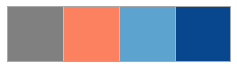

In [517]:
import random
from six.moves import cPickle as pickle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.patches import Circle
rc('text', usetex=True)
rc('text.latex', preamble='\\usepackage{color}')
from PIL import Image
import numpy as np
from scipy.misc import comb
from math import log, exp, sqrt
from collections import Counter, OrderedDict
import seaborn as sns
sns.set_context("paper")
# sns.set_context('talk')
import string
import json
import pickle
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# COLORS = ["#808080", "#3498db", "#0000b3", "#ffd480", "#e74c3c"]
blues = sns.color_palette('Blues', 10)
reds = sns.color_palette('Reds')
COLORS = ["#808080", reds[2], blues[5], blues[9]]
sns.palplot(sns.color_palette(COLORS))

# from multiprocessing import set_start_method
# try:
#     set_start_method('spawn')
# except RuntimeError:
#     pass

## word neighbors

In [507]:
# Constants
itow = json.load(open('../data/coco/cocotalk.json', 'r'))['ix_to_word']
WORDS = {int(k): v for k, v in itow.items()}
if 0 not in WORDS:
    WORDS[0] = 'EOS'
MATCH = {v: k for k,v in WORDS.items()}
del itow
FF = pickle.load(open('../data/coco/idf_coco_01.pkl', 'rb'))
F = pickle.load(open('cooc_freq.pkl', 'rb'))[0]

# utils:
def normalize(A):
    l1 = A.sum(axis=1)
    A /= l1.reshape(len(A), 1)
    return A

def invocab(ngram):
    for w in ngram:
        if w not in MATCH:
            return False
    return True

def space(xy, points, delta=1):
    x , y = xy
    xs = np.array([p[0] for p in points])
    ys = np.array([p[1] for p in points])
    while np.any(np.absolute(xs -x) < delta):
        x += delta
    while np.any(np.absolute(ys -y) < delta):
        y += delta
    return [x, y]

def exps(sim, tau=0.2, freq=False):
    if freq:
        return normalize(np.exp((sim-1 - tau * FF)/tau))
    else:
        return normalize(np.exp((sim-1)/tau))
    
sim_wiki = pickle.load(open('../data/Glove/glove_wiki_d300_w15_similarities.pkl',
                             'rb'), encoding='iso-8859-1')
sim_coco = pickle.load(open('../data/Glove/glove_coco_d300_w15_similarities.pkl','rb'))
G2_coco = pickle.load(open('../data/Glove/glove_coco_d300_w15_matrix_tsne2D.pkl', 'rb'))
G2 = pickle.load(open('../data/Glove/glove_wiki_d300_w15_matrix_tsne2D.pkl', 'rb'))


In [508]:
def cancel_proba(arr, indices):
    arr = arr.copy()
    for i in range(len(arr)):
        if i not in indices:
            arr[i] = 0
    return arr / np.sum(arr)


def plot_words_2d(ax, selected, sim, X2, NN=10, verbose=0, sens=1):
    V = np.arange(sim.shape[0])
    k = MATCH[selected]
    nbrs = sim[k].argsort()[-NN:][::-1]
    p = cancel_proba(sim[k], nbrs)
    samples = np.random.choice(V, p=p, size=(50,))
    xs = X2[samples, 0]
    ys = X2[samples, 1]
    sns.kdeplot(xs, ys, ax=ax, cut=2,
                cmap='Blues', shade=False, shade_lowest=False,
               cbar=True)
    for i in nbrs:
        if i == k:
            ax.text(X2[i,0], X2[i,1], WORDS[i], fontsize=15, color="k", weight=3)
        else:
            ax.text(X2[i,0], X2[i,1], WORDS[i], fontsize=10, color="k")
    plt.tight_layout()

In [ ]:
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
np.random.seed(1)
f, ax = plt.subplots(1,1, figsize=(6,6))
plot_words_2d(ax, 'tree', exps(sim_coco, tau=.15), NN=10, X2=G2_coco)

In [527]:
def plot_word_neighbors(axs, selected, sim1, sim2, labels,
                        NN=10, verbose=0, legend=0):
    ax2, ax = axs
    h = .08
    colors = sns.color_palette("Paired", NN)
    k = MATCH[selected]
    nbrs1 = np.flip(sim1[k].argsort()[-NN:][::-1], axis=0)
    nbrs2 = np.flip(sim2[k].argsort()[-NN:][::-1], axis=0)
    nbrs = list(set(nbrs1).union(set(nbrs2)))
    nbrs.remove(k)
    nbrs = nbrs + [k]
#     print('neighbors:', nbrs)
    wnbrs = [WORDS[i] for i in nbrs]
    simnbrs1 = [sim1[k,i] for i in nbrs]
    simnbrs2 = [sim2[k,i] for i in nbrs]
    ys = 4 / 3 * h * np.arange(len(nbrs))
    ax2.get_shared_y_axes().join(ax, ax2)
    ax2.set_xlim(1e-6, 1)
    ax2.text(1e-4,-.26,"freq", fontsize=18)
    ax2.invert_xaxis()
    ax2.yaxis.tick_right()
    freqnbrs = [F[i] for i in nbrs]
    if verbose:
        print('freq', freqnbrs)
        print('sim', simnbrs)
    ax2.barh(ys, freqnbrs, height=h,
             align='edge', color=COLORS[1], alpha=.5)
    
    ax2.set_xscale("log", nonposx='clip')
#     ax2.set_xlabel('freq')
    
    ax2.axis('off')
    ax.barh(ys+2*h/3, [0] * (len(nbrs)-1) + [1], height=h/3,
            align='edge', color=COLORS[0], alpha=.5,
           label="MLE")
    ax.barh(ys+h/3, simnbrs1, height=h/3,
            align='edge', color=COLORS[2], alpha=.7,
           label=labels[0])
    ax.barh(ys, simnbrs2, height=h/3,
            align='edge', color=COLORS[3], alpha=.7,
            label=labels[1])
    ax.set_yticks(ys + h/2)
    ax.tick_params('y', labelsize=14)
    ax.set_yticklabels(wnbrs)
    ax.set_ylim(min(ys), max(ys) + h)
    ax.set_xlim(1e-4, 1)
    ax.set_xscale("log", nonposx='clip')
    ax.set_xlabel('$r_\\tau(y|$%s$)$' % selected)
    
    if legend:
        ax.legend(fontsize=16, loc=4)
    plt.tight_layout()
#         plt.savefig('../figures/%s_nbrs_%s.png' % (prefix, WORDS[k]),
#                     dpi=300, bbox_inches='tight')


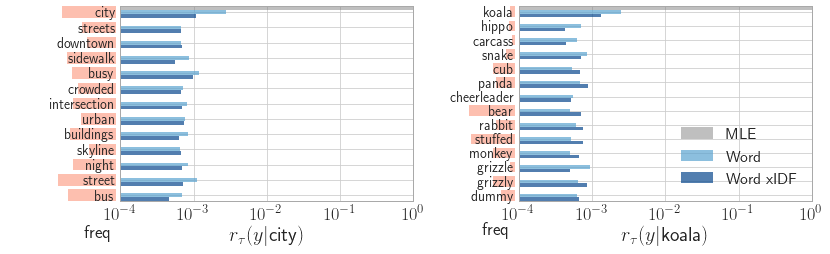

In [528]:
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
fig, axs = plt.subplots(1, 4, figsize=(12, 4),
                        gridspec_kw = {'width_ratios':[1, 3] * 2})
word = "city" #"street"
plot_word_neighbors(axs[:2], word,
                    exps(sim_coco, 0.15),
                    exps(sim_coco, 0.15, True),
                    ['Word', 'Word xIDF'])

word = "koala" #"street"
plot_word_neighbors(axs[2:4], word,
                    exps(sim_coco, 0.15),
                    exps(sim_coco, 0.15, True),
                    ['Word', 'Word xIDF'],
                   legend=1)

fig.tight_layout()
plt.subplots_adjust(wspace=0.02)

plt.savefig('../figures/words_nbrs_coco.png',
            dpi=300, bbox_inches='tight')


In [ ]:
frequent = F.argsort()[-80:][::-1]
medium = F.argsort()[1300:1380]
rare = F.argsort()[60:90]

for fr in frequent:
    print(WORDS[fr],)

In [ ]:
def skim(arr, percentile):
    th = np.percentile(arr, percentile)
    arr[arr<th] = 0
    return arr

def plot_nbrs_picks(word, ax, legend=False):
    iw = MATCH[word]
    dirac = np.zeros(sim_coco.shape[0])
    dirac[MATCH[word]] = 1
    ax.plot(dirac, c='darkred', alpha=0.5, label="MLE - $\\delta$")

    default = skim(exps(sim_coco, 0.15, False)[iw], 99.5)
    ax.plot(default, c='darkgreen', label="Tok-Reward - $r_\\tau$", alpha=.5)

    xidf = skim(exps(sim_coco, 0.15, True)[iw], 99.5)
    ax.plot(xidf, c='mediumblue', label="Tok-Reward - $r_\\tau^{IDF}$", alpha=.5)
    if legend:
        ax.legend(fontsize=15, loc=2)
    wxidf = np.nonzero(xidf)[0]
    wdef = np.nonzero(default)[0]
    wperr = 4
    sel = np.concatenate((np.array([iw]),
                          np.random.choice(wdef, wperr),
                          np.random.choice(wxidf, wperr)))
    colors = ['darkred'] + wperr * ['darkgreen'] + wperr * ['mediumblue']
    for e, (s, c) in enumerate(zip(sel, colors)):
#         print('index:', s, 'default', default[s], 'xidf', xidf[s])
        if not e:
            scale=.5
            slide = 25
            pick = 1
        else:
            if e < wperr + 1:
                pick = default[s]
                slide = -400
                scale = 5
#                 print('e:', e, WORDS[s])
            else:
                pick = xidf[s]
                slide = 100
                scale = 3

        ax.annotate(WORDS[s].encode().decode(),
                    xy=(s, pick),
                    xytext=(s + slide, scale * pick),
                    color=c,
                    fontsize=18,
    #               arrowprops=dict(facecolor='black', shrink=0.05),
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3",
                                    facecolor=c,
                                    edgecolor=c))
    ax.set_yscale("log")
    ax.set_xticks([])
    ax.set_ylabel('$r_\\tau(y|$%s$)$' % word)
#     ax.set_xlabel('$\\mathcal V$')


In [ ]:
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})

f, axs = plt.subplots(2, 1, figsize=(15, 5))
np.random.seed(1244)
plot_nbrs_picks('street', axs[0], legend=True)

np.random.seed(17)
plot_nbrs_picks('dynamite', axs[1])

plt.tight_layout()
# plt.savefig('../figures/nbrs_picks.png',
#             dpi=300, bbox_inches='tight')

## Abstract

In [ ]:
L = 800
x = np.arange(L)
y = np.zeros(L)
center = 300
a = 1e-5
y = 1/a * (1/np.pi * 1/(1+((x- center)/a)**2))
y /= np.sum(y)

if 0:
    centers = [center] + np.random.randint(low=1,
                                           high=L,
                                           size=10)
    sigmas = np.random.randint(low=1,
                               high=10,
                               size=10) / 10
    weights = [5] + np.random.randint(low=1,
                                      high=10,
                                      size=10)/2
    weights = weights / np.sum(weights)
    z = np.zeros(L)
    for w, c, s in zip(weights, centers, sigmas):
        z += w * np.exp(-(x-c)**2/2/s)
    # z += 1/30 * np.random.randn(50)
if 1:
    sigma = 10
    z = np.exp(-(x-center)**2/2/sigma**2)
z /= np.sum(z)
z = 13 * z
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
plt.figure(figsize=(6,5))
plt.plot(x, y, label='MLE')
plt.plot(x, z, label='Reward')
plt.xlim([center-12*sigma, center+12*sigma])
plt.xticks([])
plt.legend()
# plt.xticks(centers, ['jungle', 'forest', 'clearing'], rotation=45)

### Sentences

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
# print('Device:', torch.cuda.current_device())

In [4]:
GLOVE_PATH = '../../InferSent/dataset/GloVe/glove.840B.300d.txt'
import sys
sys.path.insert(0, '../../InferSent/encoder/')
model = torch.load('../../InferSent/encoder/infersent.allnli.pickle',
                   map_location=lambda storage, loc: storage)
model.set_glove_path(GLOVE_PATH)
model.build_vocab_k_words(K=100000)


/home/maha/anaconda3/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Vocab size : 100000


In [5]:
A = json.load(open('../data/coco/captions_train2014.json', 'r'))['annotations']
caps = {}
for a in A:
    if a['image_id'] in caps:
        caps[a['image_id']].append(a['caption'][:-1].lower().split())
    else:
        caps[a['image_id']] = [a['caption'][:-1].lower().split()]
del A

In [216]:
def fold(sentence, maxlen=5, bf=False):
    if isinstance(sentence, str):
        sentence = sentence.split()
    folds = len(sentence) // maxlen
    sent = r""
    for f in range(folds+1):
        if bf:
            sent += '\\bf '
        if len(sentence) > maxlen * (f+1):
            sent += ' '.join(sentence[maxlen*f: maxlen*(f+1)]) + '\n'
        else:
            sent += ' '.join(sentence[maxlen*f:])
    return sent

def highlight(sentence, indices):
#     print('Highlighting ', sentence , '@', indices)
    sent = sentence.copy()
    for ind in indices:
        sent[ind] = '\\underline{%s}' % sent[ind]
    return sent


def embed_sent(sentences):
    embeddings = model.encode(sentences, bsize=128, tokenize=False, verbose=False)
    return embeddings

def alter(sentence, vocab, tau):
    m = len(sentence)
    p = distrib(len(sentence), len(vocab), tau)
    distance = np.random.choice(range(m+1), p=p)
    sampled = sentence.copy()
    m = len(sampled)
    indices = list(range(m))
#     print('indices:', indices)
    random.shuffle(indices)
    for k in indices[:distance]:
        sampled[k] = random.choice(vocab)
    return sampled, indices[:distance]


In [292]:
def distrib(m, v, tau=0.7):
    x = [comb(m, d, exact=False) * (v-1)**d / v**m * exp(-d/tau) for d in range(m+1)]
    x = np.array(x)
    x/= np.sum(x)
    return x

def hamming(s1, s2):
    assert len(s1) == len(s2)
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def sentence_bleu(hypothesis, reference, smoothing=True, order=4, **kwargs):
    log_score = 0
    if len(hypothesis) == 0:
        return 0
    for i in range(order):
        hyp_ngrams = Counter(zip(*[hypothesis[j:] for j in range(i + 1)]))
        ref_ngrams = Counter(zip(*[reference[j:] for j in range(i + 1)]))
        numerator = sum(min(count, ref_ngrams[bigram])
                        for bigram, count in hyp_ngrams.items())
        denominator = sum(hyp_ngrams.values())
        if smoothing:
            numerator += 1
            denominator += 1
        score = numerator / denominator
        if score == 0:
            log_score += float('-inf')
        else:
            log_score += log(score) / order
    bp = min(1, exp(1 - len(reference) / len(hypothesis)))
    return exp(log_score) * bp

def alter_and_score(imid, d=2, NS=1, normalize=1, tauh=.2, V='refs'):
    sampled = OrderedDict()
    Vsub = []
    for c in caps[imid]:
        Vsub += c
    for c in caps[imid]:
        k = ' '.join(c)
        for ii in range(NS):
            if not ii:
                sampled[k] = []
            s, a = alter(c, Vsub, tau=tauh)
            sampled[k].append({'sample': s, "alter": a})
    # Embed:
    sentences = []
    for c in sampled:
        sentences.append(c)
        for s in sampled[c]:
            sentences.append(' '.join(s["sample"]))
        
    for s in sentences:
        print(s)
    embeddings = embed_sent(sentences)
    X2 = TSNE(n_components=2, verbose=0).fit_transform(embeddings)
    for c in sampled:
        for e, _ in enumerate(sampled[c]):
            sampled[c][e]['bleu'] = sentence_bleu(sampled[c][e]['sample'], c.split())
            sampled[c][e]['hamming'] = hamming(sampled[c][e]['sample'], c.split())        
    return X2, sampled

In [199]:
def plot_sentences_bar(ax, sampled, tauh=.2, taub=.2, nrefs=5):
    h = .1
    hammings = []
    bleus = []
    sentences = []
    for e, c in enumerate(sampled):
        if e >= nrefs:
            break
        sentences.append(r'\textbf{%s}' % c)
        hammings.append(0)
        bleus.append(1)
        for sabh in sampled[c]:
            sentences.append(r'%s' % ' '.join(highlight(sabh['sample'],
                                                        sabh['alter'])))
            hammings.append(sabh['hamming'])
            bleus.append(sabh['bleu'])
    if 1:
        hammings = np.array([exp(-d/tauh) for d in hammings])
        hammings /= np.sum(hammings)
        bleus = np.array([exp((bleu-1)/taub) for bleu in bleus])
        bleus /= np.sum(bleus)
            
    ys = h/4 * np.arange(2 * len(sentences))
    print('ticks:', len(ys), ys)
    ax.barh(ys[1::2], hammings[::-1], height=h/4,
            align='edge', color=COLORS[2], alpha=.7, label='$r_{hamming}$')
    ax.barh(ys[::2], bleus[::-1], height=h/4,
            align='edge', color=COLORS[1], alpha=.7, label='$r_{bleu}$')
    ax.set_yticks(ys[1::2])
    ax.set_yticklabels(sentences[::-1])
#     ax.set_xlim([1e-5, 1])
    ax.set_ylim([min(ys), max(ys)+h/4])
    ax.set_xscale("log", nonposx='clip')
    ax.legend(bbox_to_anchor=(.3, -.2), loc=3,
              ncol=2, borderaxespad=0.)


In [223]:
ids = list(caps)
pick = 242
print(caps[ids[pick]])

[['lots', 'of', 'balloons', 'floating', 'in', 'front', 'of', 'tall', 'buildings'], ['a', 'lot', 'if', 'people', 'walking', 'around', 'in', 'the', 'cit'], ['people', 'and', 'bikes', 'on', 'the', 'pavement', 'next', 'to', 'buildings.'], ['bike', 'racers', 'and', 'pedestrians', 'in', 'sunny', 'european', 'square'], ['a', 'celebration', 'in', 'a', 'parking', 'lot', 'with', 'parked', 'bikes']]


In [335]:
NS = 10
tauh = .19
X2, sampled = alter_and_score(ids[pick], NS=NS, tauh=tauh)

lots of balloons floating in front of tall buildings
lots a balloons floating in front of tall buildings
in of lots people in front of tall buildings
people of pavement floating in pedestrians of tall buildings
lots of balloons floating in front of tall buildings
front buildings. balloons racers in front of tall buildings
lots of balloons floating in a of tall buildings
lots of balloons floating racers front of tall buildings
lots of balloons floating celebration front of tall bikes
lots of balloons floating in front of tall buildings
lots of balloons floating in pedestrians of parked buildings
a lot if people walking around in the cit
a in if people walking around in the cit
a lot if people walking lot in sunny cit
a lot bikes people walking around in the cit
a lot if people walking around to the cit
a in tall bike walking around in the cit
a lot if people walking around in the cit
a lot lots if walking around pavement the cit
a lot if people walking around in the cit
a lot if people 

ticks: 22 [ 0.     0.025  0.05   0.075  0.1    0.125  0.15   0.175  0.2    0.225
  0.25   0.275  0.3    0.325  0.35   0.375  0.4    0.425  0.45   0.475  0.5
  0.525]


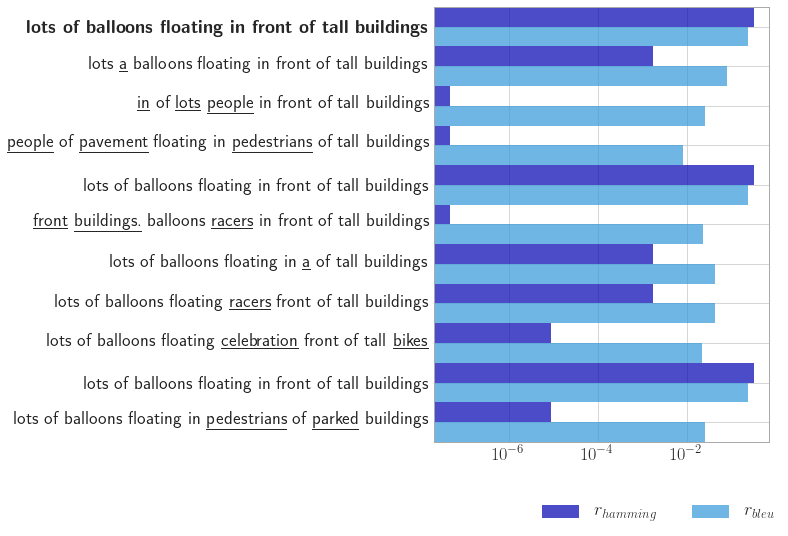

In [338]:
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
f, ax = plt.subplots(1, 1, figsize=(6, 8))
plot_sentences_bar(ax, sampled, nrefs=1, tauh=tauh)

In [498]:
def plot_sentences_2d(ax, X2, sampled, refs, pick=['hamming', "bleu"],
                      tauh=.2, taub=.2):
    keys = list(sampled)
    selected = [keys[e] for e in refs]
    for e, c in enumerate(selected):
        hammings = []
        bleus = []
        sentences = []
        sentences.append(fold(c, 4, bf=True))
        hammings.append(0)
        bleus.append(1)
        NS = len(sampled[c]) + 1
        for sabh in sampled[c]:
            if sabh['hamming']:
                sentences.append(r'%s' % fold(highlight(sabh['sample'],
                                                        sabh['alter']),
                                             4))
                hammings.append(sabh['hamming'])
                bleus.append(sabh['bleu'])
        if 1:
            hammings = np.array([exp(-d/tauh) for d in hammings])
            hammings /= np.sum(hammings)
            bleus = np.array([exp((bleu-1)/taub) for bleu in bleus])
            bleus /= np.sum(bleus)
        V = np.arange(len(sentences))
        X2ref = X2[refs[e]*NS:(refs[e]+1)*NS] 
        if 'hamming' in pick:
            print('sampling wrt (hamming):', hammings)
            samples = np.random.choice(V, p=hammings, size=(2000,))
            xs = X2ref[samples, 0]
            ys = X2ref[samples, 1]
            sns.kdeplot(xs, ys, ax=ax, cut=3,
                        cmap="Reds", shade=True, shade_lowest=False,
                        cbar=True, alpha=.6, cbar_kws={"label": "$r_\\tau$, $r:=$Hamming",
                                                      "orientation": "horizontal",
                                                      "pad": .01,
                                                      "format": "%.1e",
                                                      'shrink': 0.7})
        if 'bleu' in pick:
            print('sampling wrt (bleu):', bleus)
            samples2 = np.random.choice(V, p=bleus, size=(1000,))
            xs2 = X2ref[samples2, 0]
            ys2 = X2ref[samples2, 1]
            sns.kdeplot(xs2, ys2, ax=ax, cut=3,
                        cmap='Blues', shade=True, shade_lowest=False,
                        cbar=True, alpha=.5, cbar_kws={"label": "$r_\\tau$, $r:=$Bleu-4",
                                                        "orientation": "horizontal",
                                                        "pad": .01,
                                                        "format": "%.1e",
                                                        'shrink': 0.7})
        for i in V:
            ax.text(X2ref[i,0], X2ref[i,1], sentences[i], fontsize=18, color="k")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim([np.min(X2ref[:,0])-5, np.max(X2ref[:,0])+15])
        ax.set_ylim([np.min(X2ref[:,1])-5, np.max(X2ref[:,1])+10])
        
    
    
#         pal = sns.dark_palette("palegreen", as_cmap=True, reverse=True)
#         pal = sns.cubehelix_palette(8, start=2, rot=0, dark=0.1, light=1,
#                                     reverse=False,
#                                     as_cmap=True)

sampling wrt (bleu): [ 0.17370107  0.13235844  0.09965763  0.07467689  0.09741128  0.1132822
  0.1132822   0.09597265  0.09965763]
sampling wrt (hamming): [ 0.28512947  0.14768012  0.03961703  0.03961703  0.03961703  0.14768012
  0.14768012  0.07648953  0.07648953]


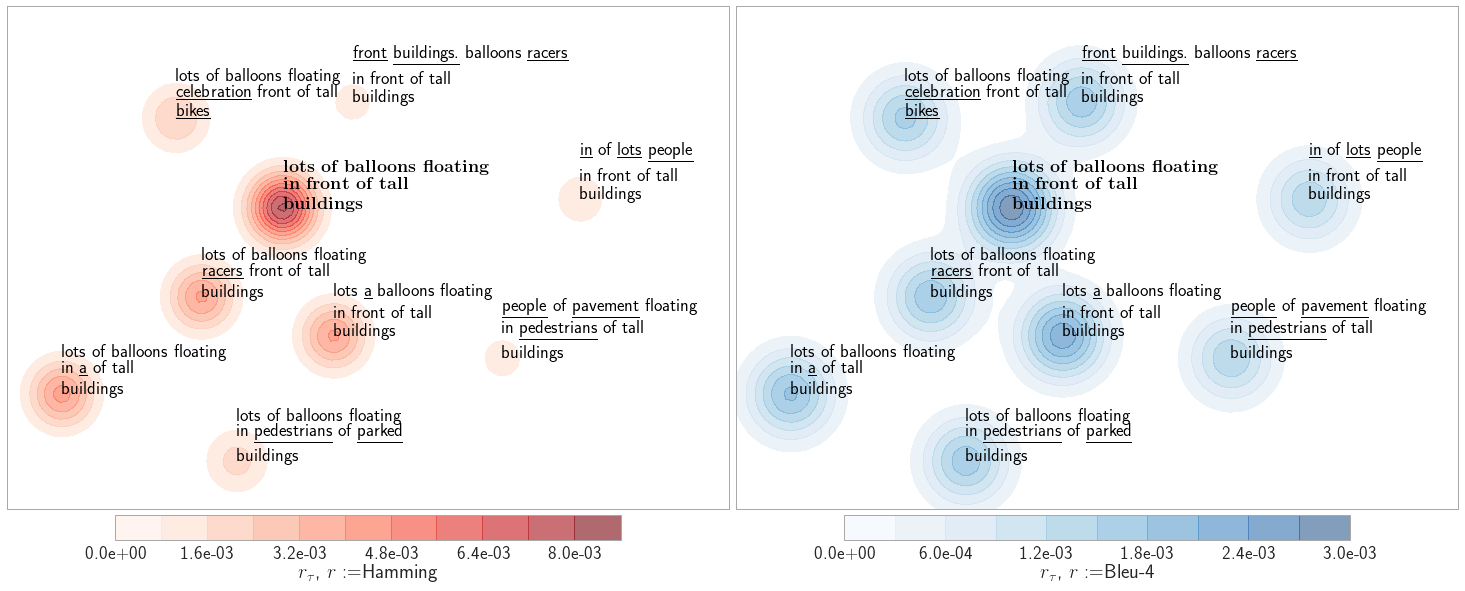

In [499]:
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})

f, ax = plt.subplots(1, 2, figsize=(26, 11))
plot_sentences_2d(ax[1], X2, sampled, refs=[0], pick=['bleu'],
                  taub=.8)
plot_sentences_2d(ax[0], X2, sampled, refs=[0], pick=['hamming'],
                  tauh=8*tauh, taub=.8)

# f.tight_layout()
plt.subplots_adjust(wspace=.01)
plt.savefig('../figures/sentences.png',
            dpi=300, bbox_inches='tight')

### Hamming tau

In [ ]:
m = 16
V1 = 30
taus1 = [.2, .3, .4]
V2 = 180
taus2= [.15,.17, .2]
V3 = 9800
taus3= [0.09, 0.10, 0.12]
V4 = 300
taus4= [0.13, 0.15, 0.17]
yt = .28
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'black'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
fig, axs = plt.subplots(2, 2, figsize=(16, 16), sharey=True)
markers = ['*', '^', 'o', 's']
for i, tau in enumerate(taus1):
    axs[0,0].plot(range(m+1) , distrib(m, V1, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[0,0].legend()
axs[0,0].set_xticks(4 * np.arange(m//4 +1))
axs[0,0].text(.4*m, yt, '$V_{pool}=%d$'% V1)
axs[1,0].set_xlabel('d')

for i, tau in enumerate(taus2):
    axs[0,1].plot(range(m+1),
                  distrib(m, V2, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[0,1].legend()
axs[0,1].set_xticks(4 * np.arange(m//4 +1))
axs[0,1].text(.4*m, yt, '$V_{pool}=%d$'% V2)
axs[0,1].set_xlabel('d')

for i, tau in enumerate(taus3):
    axs[1,0].plot(range(m+1),
                  distrib(m, V3, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[1,0].legend()
axs[1,0].set_xticks(4 * np.arange(m//4 +1))
axs[1,0].text(.4*m, yt, '$V_{pool}=%d$'% V3)
axs[1,0].set_xlabel('d')


m = 50
for i, tau in enumerate(taus4):
    axs[1,1].plot(range(m+1),
                  distrib(m, V4, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[1,1].legend()
axs[1,1].set_xticks(4 * np.arange(m//4 +1))
axs[1,1].text(.4*m, yt, '$V_{pool}=%d$'% V4)
axs[1,1].set_xlabel('d')
plt.tight_layout()

# plt.savefig('../figures/hamming_q.png', dpi=400, bbox_inches='tight')